# Статистика, DS-поток
## Практическое задание 13


**Правила:**

* Дедлайн **7 ноября 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 15 баллов.

**Важность задач:**

* *высокая:* задача 1.

In [54]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from numpy import linalg as la

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
# sns.set_style("dark")
sns.set(font_scale=1.3, style='whitegrid', palette='Set2')

import plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import gui
from tqdm.notebook import tqdm
from time import time

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%ls
%cd 'gdrive/MyDrive/DS/task13'

gdrive/  sample_data/
/content/gdrive/MyDrive/DS/task13


In [137]:
%%shell
jupyter nbconvert --to html 'task13.ipynb'

[NbConvertApp] Converting notebook task13.ipynb to html
[NbConvertApp] Writing 1009975 bytes to task13.html


## Задача 1

**1.** Реализуйте логистическую регрессию с регуляризацией для трех вариантов поиска оценки параметров:
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск с размером батча 5-10;
* IRLS.

Для измерения времени работы **каждого** шага используйте 

`from time import time`

*Замечания.* 

1. Для чистоты эксперимента время шага внутри цикла нужно замерять от конца предыдущего шага до конца текущего, а не от начала текущего шага.
2. Иногда при подсчете сигмоиды и оптимизируемого функционала могут возникать вычислительные ошибки. Для их избежания существуют специальные трюки.
    * [How to Evaluate the Logistic Loss and not NaN trying](http://fa.bianp.net/blog/2019/evaluate_logistic/)
    * [The log-sum-exp trick in Machine Learning](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/)
    * [Exp-normalize trick](https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/)<br>
3. Трюки не обязательно реализовывать самостоятельно, можете воспользоваться функциями для них из `scipy`, `numpy`: 
    * [`scipy.special.logsumexp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html);
    * [`numpy.logaddexp`](https://numpy.org/doc/stable/reference/generated/numpy.logaddexp.html).
4. В методе IRLS можно добавить малый регуляризатор даже если регуляризации нет для исключения вычислительных проблем.

In [74]:
class LogisticRegression():
    '''
    Модель логистической регрессии. Имеет следующие гиперпараметры:
    
    :param alpha: параметр регуляризации. 
                     Если равно 0, то регуляризация не происходит.
    :param lr: константа, на которую домножаем градиент при обучении
    :param eps: ограничение на норму невязки в случае
                   если используется критерий criterion='eps'
    :param max_iter: ограничение на кол-во итераций в случае 
                        если используется критерий criterion='max_iter'
    :param method: если равно 'gd', то используется обычный градиентный спуск,
                   если равно 'sgd', то используется стохастический 
                        градиентный спуск,
                   если равно 'irls', то используется метод IRLS.
    :param criterion: если равно 'eps', то используем ограничение 
                        на норму невязки,
                      если равно 'max_iter', то используем ограничение 
                        на количество итераций
    :param fit_intercept: указывает, следует ли добавить константу в признаки
    :param save_history: указывает, следует ли сохранять историю обучения
    '''
    
    def __init__(self, alpha=0, lr=0.5, eps=1e-3, max_iter=1e5, 
                 method='gd', criterion='max_iter', 
                 fit_intercept=True, save_history=True,
                 batch_sizes=(5, 10)):
        '''Создает модель и инициализирует параметры.'''
        
        criterion_error_msg = 'выбран неправильный критерий остановки'
        assert criterion in ['max_iter', 'eps'], criterion_error_msg
        
        method_error_msg = 'выбран неправильный метод'
        assert method in ['gd', 'sgd', 'irls'], method_error_msg

        self.alpha = alpha
        self.lr = lr
        self.eps = eps
        self.max_iter = max_iter
        self.criterion = criterion
        self.method = method
        self.step_method = getattr(self, f'_{method}_step')
        self.fit_intercept = fit_intercept
        self.batch_sizes = batch_sizes
        self.save_history = save_history
        self.history = {  # для хранения истории обучения
            'weights':[],
            'exec_time':[],
            'log_likelihood':[]
        }

        self.n_iter_ = 0  # произведенное число итераций

    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _log_sigmoid(x):
        return np.logaddexp(0, -x)
    
    def _log_likelihood(self, X, y):
        product = X@self._theta
        return -(y @ self._log_sigmoid(product) + (1 - y) @ self._log_sigmoid(-product))

    def _grad(self, X, y):
        return X.T @ (self._sigmoid(X @ self._theta) - y)

    def _gd_reg(self):
        return 2 * self.alpha * self._theta

    def _gd_step(self, X, y):
        return self._grad(X, y) + self._gd_reg()
    
    def _sgd_step(self, X, y):
        batch_size = sps.randint.rvs(low=self.batch_sizes[0], high=self.batch_sizes[1]+1)
        batch_index = sps.randint.rvs(low=0, high=X.shape[0], size=batch_size)
        X_batch = X[batch_index]
        y_batch = y[batch_index]
        return X.shape[0] / batch_size * self._grad(X_batch, y_batch) + self._gd_reg()
    
    def _hessian(self, X, y):
        sigm = self._sigmoid(X @ self._theta)
        V = np.diag(sigm * (1 - sigm))  # with regularization
        return X.T @ V @ X + np.eye(X.shape[1]) * 2 * self.alpha

    def _irls_step(self, X, y):
        return la.inv(self._hessian(X, y)) @ self._gd_step(X, y)

    def _criterion(self):
        if self.criterion == 'max_iter':
            return self.n_iter_ >= self.max_iter
        return la.norm(self._step) < self.eps
    
    def _add_intercept(self, X):
        '''
        Добавляем свободный коэффициент к нашей модели. 
        Это происходит путем добавления вектора из 1 к исходной матрице.
        
        :param X: исходная матрица признаков
        :return: матрица X с добавленным свободным коэффициентов
        '''
        
        X_copy = np.full((X.shape[0], X.shape[1] + 1), fill_value=1)
        X_copy[:, :-1] = X

        return X_copy

    
    def fit(self, X, Y):
        '''
        Обучает модель логистической регресии с помощью выбранного метода,
        пока не выполнится критерий остновки self.criterion.
        Также, в случае self.save_history=True, добавляет в self.history 
        текущее значение оптимизируемого функционала 
        и время обновления коэффициентов. 
        
        :param X: матрица признаков
        :param Y: истинные метки
        '''
        
        assert X.shape[0] == Y.shape[0]

        if self.fit_intercept:  # добавляем свободный коэфициент
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()
        
        self._theta = np.zeros(shape=X_copy.shape[1])  # коэффициенты модели
        
        start = time()
        while True:
            self.n_iter_ += 1
            self._step = self.lr * self.step_method(X_copy, Y)
            self._theta -= self._step

            end = time()
            delta_time = end - start
            if self.save_history:
                # self.history.append({
                #     'weights':self._theta.copy(),
                #     'exec_time':delta_time,
                #     'log_likelihood':self._log_likelihood(X_copy, Y)
                # })
                self.history['weights'].append(self._theta.copy())
                self.history['exec_time'].append(delta_time)
                self.history['log_likelihood'].append(self._log_likelihood(X_copy, Y))

            if self._criterion():
                break
            start = end

        self.coef_ = self._theta[:-1] if self.fit_intercept else self._theta  # коэффициенты модели
        self.intercept_ = self._theta[-1] if self.fit_intercept else 0 # свободный коэффициент
        
        return self
        
    def predict(self, X):
        '''
        Применяет обученную модель к данным 
        и возвращает точечное предсказание (оценку класса).
        
        :param X: матрица признаков
        :return: предсказание с размерностью (n_test, )
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.theta.shape[0]
        
        return (self._sigmoid(X_copy @ self._theta) >= 0.5).astype(np.int64)
        
    def predict_proba(self, X):
        '''
        Применяет обученную модель к данным
        и возвращает предсказание вероятности классов 0 и 1.
        
        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''

        if self.fit_intercept:
            X_copy = self._add_intercept(X)
        else:
            X_copy = X.copy()

        assert X_copy.shape[1] == self.theta.shape[0]

        ps_1 = self._sigmoid(X_copy @ self._theta)
        
        return np.vstack([1 - ps_1, ps_]).T

Рассмотрим игрушечный датасет на $30$ признаков `load_breast_cancer` из библиотеки `sklearn`. Это относительно простой для бинарной классификации датасет по диагностике рака молочной железы.

Ради интереса можно прочитать описание признаков.

In [25]:
dataset = load_breast_cancer()
dataset['DESCR'].split('\n')[11:31]

['    :Attribute Information:',
 '        - radius (mean of distances from center to points on the perimeter)',
 '        - texture (standard deviation of gray-scale values)',
 '        - perimeter',
 '        - area',
 '        - smoothness (local variation in radius lengths)',
 '        - compactness (perimeter^2 / area - 1.0)',
 '        - concavity (severity of concave portions of the contour)',
 '        - concave points (number of concave portions of the contour)',
 '        - symmetry',
 '        - fractal dimension ("coastline approximation" - 1)',
 '',
 '        The mean, standard error, and "worst" or largest (mean of the three',
 '        worst/largest values) of these features were computed for each image,',
 '        resulting in 30 features.  For instance, field 0 is Mean Radius, field',
 '        10 is Radius SE, field 20 is Worst Radius.',
 '',
 '        - class:',
 '                - WDBC-Malignant',
 '                - WDBC-Benign']

Разделим нашу выборку на обучающую и тестовую:

In [32]:
X, Y = dataset['data'], dataset['target']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

При использовании регуляризации данные необходимо нормализовать. Воспользуемся для этого классом `StandardScaler` из библиотеки `sklearn`. 

In [33]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test

(array([[-1.44075296, -0.43531947, -1.36208497, ...,  0.9320124 ,
          2.09724217,  1.88645014],
        [ 1.97409619,  1.73302577,  2.09167167, ...,  2.6989469 ,
          1.89116053,  2.49783848],
        [-1.39998202, -1.24962228, -1.34520926, ..., -0.97023893,
          0.59760192,  0.0578942 ],
        ...,
        [ 0.04880192, -0.55500086, -0.06512547, ..., -1.23903365,
         -0.70863864, -1.27145475],
        [-0.03896885,  0.10207345, -0.03137406, ...,  1.05001236,
          0.43432185,  1.21336207],
        [-0.54860557,  0.31327591, -0.60350155, ..., -0.61102866,
         -0.3345212 , -0.84628745]]),
 array([[-0.46649743, -0.13728933, -0.44421138, ..., -0.19435087,
          0.17275669,  0.20372995],
        [ 1.36536344,  0.49866473,  1.30551088, ...,  0.99177862,
         -0.561211  , -1.00838949],
        [ 0.38006578,  0.06921974,  0.40410139, ...,  0.57035018,
         -0.10783139, -0.20629287],
        ...,
        [-0.73547237, -0.99852603, -0.74138839, ..., -

Проверяем, что все работает

In [78]:
regr = LogisticRegression(method='gd', lr=1e-2, max_iter=10000)
regr.fit(X_train, Y_train)
regr.history['exec_time'][-20:], regr.history['log_likelihood'][-20:]

([0.00017714500427246094,
  0.00018835067749023438,
  0.00017714500427246094,
  0.00017642974853515625,
  0.0001761913299560547,
  0.00018215179443359375,
  0.00017595291137695312,
  0.00019168853759765625,
  0.0001811981201171875,
  0.0001761913299560547,
  0.0001811981201171875,
  0.00017714500427246094,
  0.0001857280731201172,
  0.0001811981201171875,
  0.0001742839813232422,
  0.00017404556274414062,
  0.00018072128295898438,
  0.00017452239990234375,
  0.0001857280731201172,
  0.00019502639770507812],
 [-60.27009620492167,
  -60.27005946913272,
  -60.2700227389451,
  -60.269986014357485,
  -60.269949295368534,
  -60.26991258197689,
  -60.26987587418125,
  -60.26983917198025,
  -60.26980247537256,
  -60.26976578435685,
  -60.269729098931776,
  -60.26969241909599,
  -60.269655744848194,
  -60.26961907618703,
  -60.26958241311115,
  -60.26954575561925,
  -60.26950910370999,
  -60.26947245738204,
  -60.26943581663403,
  -60.269399181464685])

In [79]:
regr = LogisticRegression(method='sgd', lr=1e-2, max_iter=10000)
regr.fit(X_train, Y_train)
regr.history['exec_time'][-20:], regr.history['log_likelihood'][-20:]

([0.00036406517028808594,
  0.0003707408905029297,
  0.00038814544677734375,
  0.0003638267517089844,
  0.0003833770751953125,
  0.00036787986755371094,
  0.00036978721618652344,
  0.00038504600524902344,
  0.0003829002380371094,
  0.00036907196044921875,
  0.0003788471221923828,
  0.0003566741943359375,
  0.0003826618194580078,
  0.0003685951232910156,
  0.0003638267517089844,
  0.0003788471221923828,
  0.0003666877746582031,
  0.0003733634948730469,
  0.0003826618194580078,
  0.00036406517028808594],
 [-103.45690192468504,
  -96.42805628007291,
  -96.45237439704351,
  -109.93743480844942,
  -110.74300300053511,
  -114.5714323514678,
  -106.83721069920587,
  -103.5921812286455,
  -104.62399599966642,
  -104.66421980564196,
  -109.15525246507062,
  -102.54841669074936,
  -102.59057839834416,
  -102.65694771571187,
  -100.89681401760049,
  -97.49001220296012,
  -94.43804905934432,
  -95.62015582134583,
  -95.60675806145363,
  -95.62978067444745])

In [80]:
regr = LogisticRegression(method='irls', lr=1e-2, max_iter=1000)
regr.fit(X_train, Y_train)
regr.history['exec_time'][-20:], regr.history['log_likelihood'][-20:]

([0.001344919204711914,
  0.001436471939086914,
  0.001340627670288086,
  0.0013473033905029297,
  0.0014548301696777344,
  0.0013380050659179688,
  0.0013523101806640625,
  0.0014109611511230469,
  0.001348733901977539,
  0.0013458728790283203,
  0.0013506412506103516,
  0.001356363296508789,
  0.0013980865478515625,
  0.0013573169708251953,
  0.0013651847839355469,
  0.001356363296508789,
  0.0013611316680908203,
  0.0013570785522460938,
  0.0013871192932128906,
  0.0013549327850341797],
 [-59.91663539378756,
  -59.9164604293053,
  -59.91628731566978,
  -59.9161160308734,
  -59.915946553194345,
  -59.915778861192564,
  -59.9156129337057,
  -59.91544874984517,
  -59.91528628899222,
  -59.91512553079422,
  -59.91496645516083,
  -59.91480904226023,
  -59.914653272515636,
  -59.91449912660153,
  -59.91434658544031,
  -59.91419563019871,
  -59.91404624228437,
  -59.91389840334254,
  -59.91375209525276,
  -59.91360730012555])

(IRLS тащит, по качеству, но не по времени на первый взгляд)

**2.** Теперь обучите три модели логистической регрессии без регуляризации с помощью методов
* обычный градиентный спуск;
* стохастический mini-batch градиентный спуск;
* IRLS.

Постройте график, на котором нанесите три кривые обучения, каждая из которых отображает зависимость оптимизируемого функционала от номера итерации метода. **Функционал должен быть одинаковый для всех моделей: логарифм правдоподобия без минусов**. Нарисуйте также график зависимости этого функционала от времени работы метода. Сделайте выводы. Что будет при обучении на датасете, в котором больше строк, а число столбцов останется прежним?

*Замечания:* 
* Все графики должны быть информативны, с подписанными осями и т.д..
* Для чистоты эксперимента желательно не запускать в момент обучения другие задачи и провести обучение несколько раз, усреднив результаты.

In [82]:
methods = ['gd', 'sgd', 'irls']
n_exps = 20

results = dict()

for method in methods:
    histories = []
    times = []
    for _ in tqdm(range(n_exps)):
        regr = LogisticRegression(method=method, lr=1e-2, max_iter=1000)
        regr.fit(X_train, Y_train)
        histories.append(regr.history['log_likelihood'])
        times.append(regr.history['exec_time'])
    results[method] = (np.array(histories).mean(axis=0), np.cumsum(np.array(times).mean(axis=0)))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(уже по tqdm видно, как справляются по времени разные алгоритмы)

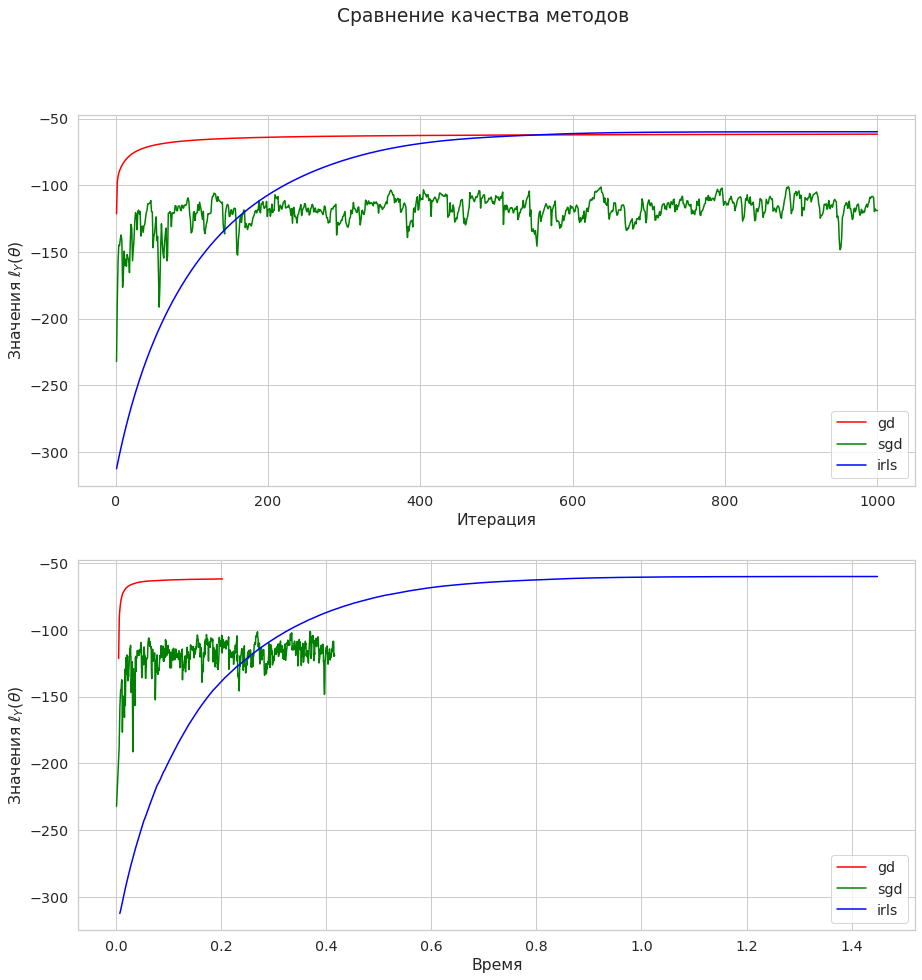

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

plt.suptitle('Сравнение качества методов')

ax = axs[0]
ax.set_ylabel('Значения $\\ell_{Y}(\\theta)$')
ax.set_xlabel('Итерация')
for method, c in zip(methods, ['r', 'g', 'b']):
    y = results[method][0]
    ax.plot(np.arange(y.shape[0]) + 1, y, label=method, c=c)
ax.legend()

ax = axs[1]
ax.set_ylabel('Значения $\\ell_{Y}(\\theta)$')
ax.set_xlabel('Время')
for method, c in zip(methods, ['r', 'g', 'b']):
    ax.plot(results[method][1], results[method][0], label=method, c=c)
ax.legend()

plt.show()

**3.** Сравните два реализованных критерия остановки по количеству проведенных итераций: 
* евклидова норма разности текущего и нового векторов весов стала меньше, чем $10^{-4}$;
* ограничение на число итераций (например, $10000$). 

Используйте градиентный спуск.

In [140]:
params = [
    {'criterion':'eps', 'eps':1e-4},
    {'criterion':'max_iter', 'max_iter':10000}
]
n_exps = 20

results = dict()

for param in params:
    regr = LogisticRegression(method='sgd', lr=1e-3, **param)
    regr.fit(X_train, Y_train)
    histories = regr.history['log_likelihood']
    times = regr.history['exec_time']

    results[param['criterion']] = (np.array(histories), np.cumsum(np.array(times)))

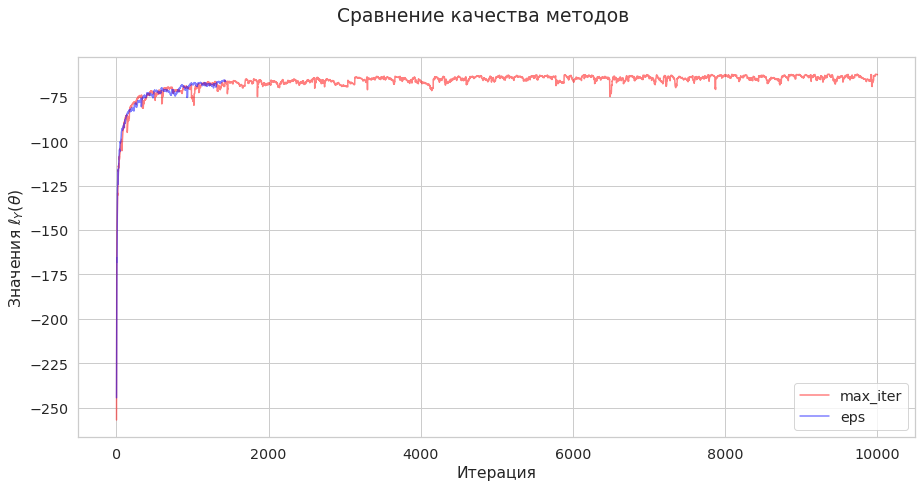

In [141]:
plt.figure(figsize=(15, 7))

plt.suptitle('Сравнение качества методов')

plt.ylabel('Значения $\\ell_{Y}(\\theta)$')
plt.xlabel('Итерация')
for crit, c in zip(['max_iter', 'eps'], ['r', 'b']):
    y = results[crit][0]
    plt.plot(np.arange(y.shape[0]) + 1, y, label=crit, c=c, alpha=0.5)

plt.legend()
plt.show()

**Вывод**: останавливаемся, когда уже получили более или менее приличный ответ в случае eps (это может случиться достаточно быстро). В случае max_iter пытаемся улучшить ответ, даже если это не получается

**4.** Рассмотрите как влияет размер шага (`learning rate`) на качество модели. Обучите каждую модель одинаковое число итераций (например, 10000), а затем посчитайте качество. Воспользуйтесь ограничением на число итераций в качестве критерия остановки, так как для больших `learning rate` у вас может не сойтись модель. Используйте стохастический градиентный спуск. Сделайте выводы.

In [111]:
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10]

In [113]:
results = dict()

for lr in lrs:
    regr = LogisticRegression(method='sgd', lr=lr, max_iter=1000)
    regr.fit(X_train, Y_train)
    histories = regr.history['log_likelihood']

    results[lr] = np.array(histories)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning:

overflow encountered in exp



Постройте кривые обучения для различных `learning rate`. Не обязательно рассматривать все `learning rate`, так как их слишком много, и график будет нагроможден. Возьмите около половины из них. Какой `learning rate` лучше выбрать? Чем плохи маленькие и большие `learning rate`?

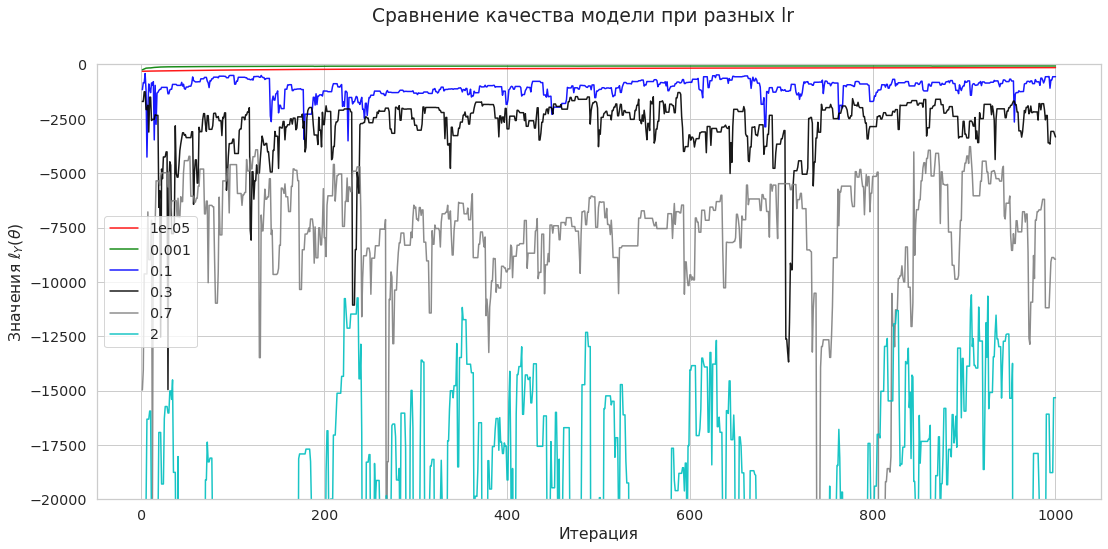

In [126]:
choose_lr = lrs[::2]

plt.figure(figsize=(18, 8))

plt.suptitle('Сравнение качества модели при разных lr')

plt.ylabel('Значения $\\ell_{Y}(\\theta)$')
plt.xlabel('Итерация')
for lr, c in zip(choose_lr, ['r', 'g', 'b', 'k', 'grey', 'c']):
    y = results[lr]
    plt.plot(np.arange(y.shape[0]) + 1, y, label=lr, c=c, alpha=0.9)

plt.ylim(-20000, 0)
plt.legend()
plt.show()

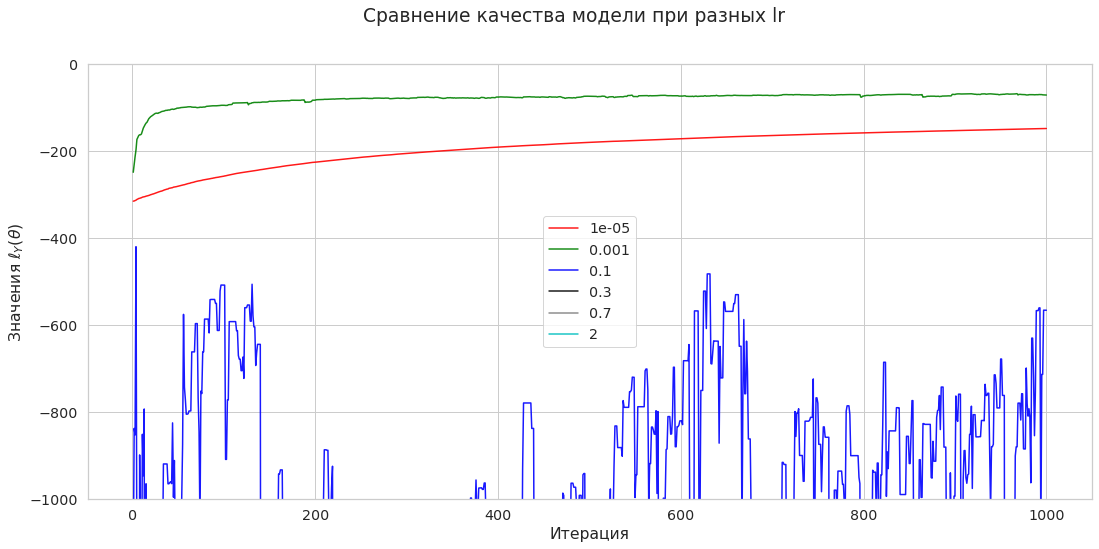

In [127]:
plt.figure(figsize=(18, 8))

plt.suptitle('Сравнение качества модели при разных lr')

plt.ylabel('Значения $\\ell_{Y}(\\theta)$')
plt.xlabel('Итерация')
for lr, c in zip(choose_lr, ['r', 'g', 'b', 'k', 'grey', 'c']):
    y = results[lr]
    plt.plot(np.arange(y.shape[0]) + 1, y, label=lr, c=c, alpha=0.9)

plt.ylim(-1000, 0)
plt.legend()
plt.show()

Большой learning rate:
 * \+ Модели быстро приближаются к окрестности правильного решения
 * \- Могут начать прыгать вокруг правильного решения, не сходясь к нему

Маленький learning rate:
 * \- Медленнно приближаются к окрестности правильного решения
 * \+ Будут хорошо и аккуратно сходиться к правильному ответу

Поэтому, например, в данном случае сработал "средний" learning rate, который и сходился хорошо, и не прыгал слишком сильно. 

Вообще говоря, вместо фиксированного eps можно брать что-то адаптивное (вроде шага Голдштейна-Армийо)

**5.** Рассмотрите несколько моделей, полученные при помощи GD, в которых установите не менее 5-ти различных коэффициентов регуляризации, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество, сделайте выводы. Под качеством подразумевается значение какой-либо выбранной вами метрики качества классификации.

In [138]:
alphas = [0, 0.1, 0.5, 1, 2, 5]
params = {'criterion':'eps', 'eps':1e-4, 'lr':1e-3}
results = dict()

for alpha in tqdm(alphas):
    regr = LogisticRegression(method='gd', **params, alpha=alpha)
    regr.fit(X_train, Y_train)
    histories = regr.history['log_likelihood']

    results[alpha] = np.array(histories)

  0%|          | 0/6 [00:00<?, ?it/s]

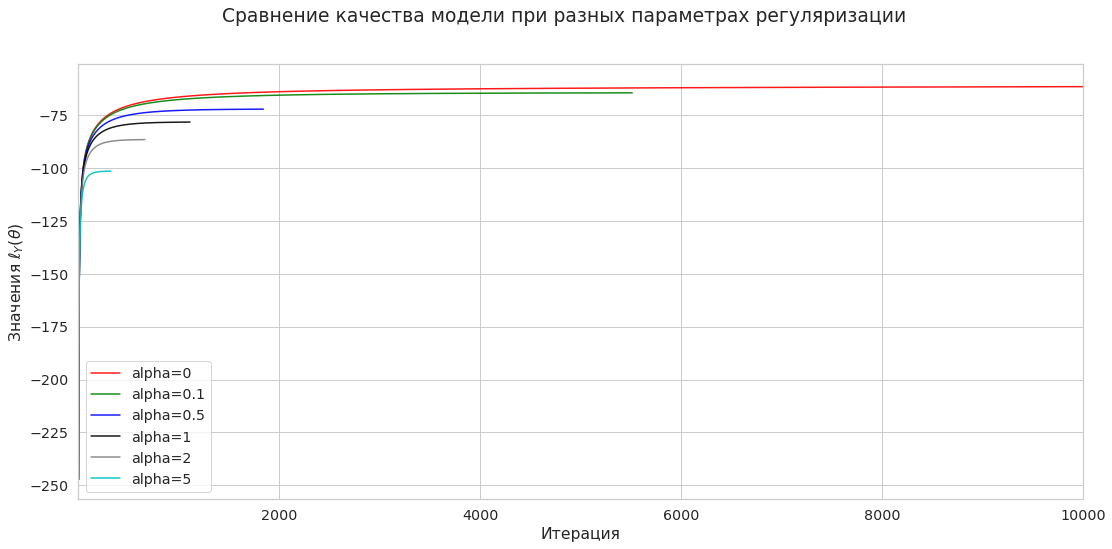

In [139]:
plt.figure(figsize=(18, 8))

plt.suptitle('Сравнение качества модели при разных параметрах регуляризации')

plt.ylabel('Значения $\\ell_{Y}(\\theta)$')
plt.xlabel('Итерация')
for alpha, c in zip(alphas, ['r', 'g', 'b', 'k', 'grey', 'c']):
    y = results[alpha]
    plt.plot(np.arange(y.shape[0]) + 1, y, label=f'alpha={alpha}', c=c, alpha=0.9)

plt.xlim(1, 10000)
plt.legend()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

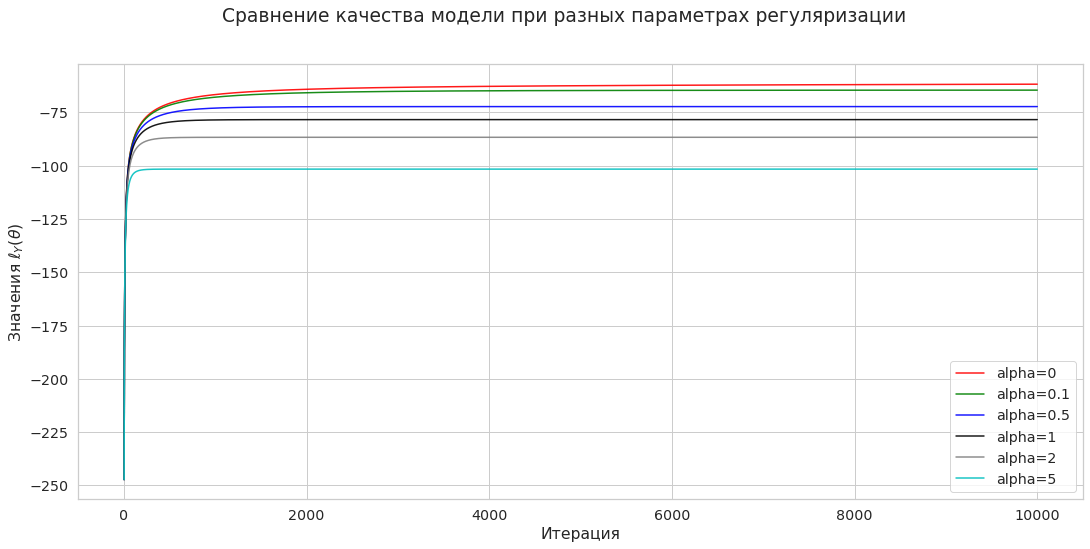

In [133]:
alphas = [0, 0.1, 0.5, 1, 2, 5]
params = {'criterion':'max_iter', 'max_iter':10000, 'lr':1e-3}
results = dict()

for alpha in tqdm(alphas):
    regr = LogisticRegression(method='gd', **params, alpha=alpha)
    regr.fit(X_train, Y_train)
    histories = regr.history['log_likelihood']

    results[alpha] = np.array(histories)

plt.figure(figsize=(18, 8))

plt.suptitle('Сравнение качества модели при разных параметрах регуляризации')

plt.ylabel('Значения $\\ell_{Y}(\\theta)$')
plt.xlabel('Итерация')
for alpha, c in zip(alphas, ['r', 'g', 'b', 'k', 'grey', 'c']):
    y = results[alpha]
    plt.plot(np.arange(y.shape[0]) + 1, y, label=f'alpha={alpha}', c=c, alpha=0.9)

# plt.ylim(-20000, 0)
plt.legend()
plt.show()

**Вывод**: При регуляризации шаг уменьшается быстрее, но результаты становятся хуже

**6.** Возьмите лучшую модель с предыдущего шага. В исходной выборке оставьте только два произвольных признака и обучите на них модель без использования свободного параметра. Визуализируйте предсказания вероятностей класса $1$ для модели.

In [ ]:
<...>

**Вывод:** <...>